# API

In [1]:
from scipy import interpolate
from scipy.optimize import curve_fit

In [2]:
def plane(xdata, mx, my, C):  #2D plane used to fit background

    xdata = np.array(xdata)
    intensities = np.zeros(len(xdata))    
    intensities = C + xdata[:,0]*mx + xdata[:,1]*my   
    return intensities

In [3]:
#define refinment function for CDW peaks
def spot_pos_refine(good_spot, pattern, y_guess, x_guess,x_low_limit=0,y_low_limit=0,x_high_limit=128,y_high_limit=128,bkg_limit=3,peak_limit=1):   #T labels the specific diffraction pattern (I convert from 4d to 3d dataset during analysis) and the y_guess and x_guess are the initial guesses for the peak position
    step = ( peak_limit ) / 4
    if good_spot == 1:
        
        #Load the diff pattern
        # pattern = exp_data[int(T),:,:] + 0

        x_int = round(x_guess) #Round the guess to the nearest pixel to begin with
        y_int = round(y_guess)
    
        #Define the size of the initial (large) fitting window
        FW_half = 2 #total size of fitting window = FW_half*2 + 1
        FW = pattern[ x_int - FW_half : x_int + FW_half + 1 , y_int - FW_half : y_int + FW_half + 1 ]

        #Find the local maximum in the FW, and return the shifts needed to bring this pixel to the FW center
        max_shift = np.unravel_index(np.argmax(FW), FW.shape)
    
        #Update x and y guess based on the local max
        x_updated = (x_int + (max_shift[0] - FW_half))
        y_updated = (y_int + (max_shift[1] - FW_half))
    
        #Make sure that the updated peak position isn't outside the detector limits
        if x_updated > x_low_limit and x_updated < x_high_limit and y_updated > y_low_limit and y_updated < y_high_limit:                

            x_PAD = np.arange(0,128,1)
            y_PAD = np.arange(0,128,1)

            f = interpolate.interp2d(x_PAD, y_PAD, pattern, kind='linear')
                
            x_FW = np.arange( x_updated - bkg_limit , x_updated + bkg_limit ,  step)  
            y_FW = np.arange( y_updated - bkg_limit , y_updated + bkg_limit ,  step)  
                
            #FW = fitting window
            FW = f( y_FW, x_FW )  #Upsample the data near the peak using linear interpolation. Upsampling is defined by 'step'
            
            xdata_all = []
            xdata_bkg = []
            intensities_bkg = []

            #Iterate through all points in fitting window, and determine if they are in the background region
            for i in range (0, len(x_FW)):
                for j in range (0, len(y_FW)):
                        
                    xdata_all.append([ x_FW[i], y_FW[j] ])
                        
                    distance = ( ( x_FW[i] - x_updated )**2  +  ( y_FW[j] - y_updated )**2 )**0.5
                        
                    if distance > peak_limit and distance < bkg_limit:
                            
                        xdata_bkg.append([ x_FW[i], y_FW[j] ])
                        intensities_bkg.append( FW[i,j] )
            
            
            #Fit background datapoints with 2D plane
            p0 = [ np.mean(intensities_bkg), 0 , 0]
            popt,pcov = curve_fit(plane, xdata_bkg, intensities_bkg, p0 = p0)

            bkg_fitted = plane(xdata_all, *popt)
            bkg_fitted = np.reshape(bkg_fitted, (len(x_FW),len(y_FW)))
                
            #Subtract the fitted background plane from the fitting window
            FW = FW - bkg_fitted
            
            #Discared all datapoints outside of 'peak region'
            for i in range (0, len(x_FW)):
                for j in range (0, len(y_FW)):
                                                
                    distance = ( ( x_FW[i] - x_updated )**2  +  ( y_FW[j] - y_updated )**2 )**0.5
                        
                    if distance > peak_limit:
                            
                        FW[i,j] = 0
                
            #Normalized data to integral unity
            FW = FW / np.sum(FW)
            
            #Perform COM calculation along x and y axes independently
            FW_integrated_x = np.sum(FW, axis = 1) #average along y-axis
            COM_x = np.dot(x_FW, FW_integrated_x) #Compute COMx
            FW_integrated_y = np.sum(FW, axis = 0) #average along y-axis  
            COM_y = np.dot(y_FW, FW_integrated_y) #Compute COMx 

            #Update peak position based on first COM calculation
            x_refined = COM_x
            y_refined = COM_y
            
            #Check to make sure the refined peak positions are still within 128 x 128 pixel limits
            if x_refined > x_low_limit and x_refined < x_high_limit and y_refined > y_low_limit and y_refined < y_high_limit:   
                
                #Repeat everything above, but with refined starting point
                x_FW = np.arange( x_refined - bkg_limit , x_refined + bkg_limit ,  step)  
                y_FW = np.arange( y_refined - bkg_limit , y_refined + bkg_limit ,  step)  
                
                FW = f( y_FW, x_FW )
            
                xdata_all = []
                xdata_bkg = []
                intensities_bkg = []

                for i in range (0, len(x_FW)):
                    for j in range (0, len(y_FW)):
                        
                        xdata_all.append([ x_FW[i], y_FW[j] ])
                        
                        distance = ( ( x_FW[i] - x_refined )**2  +  ( y_FW[j] - y_refined )**2 )**0.5
                        
                        if distance > peak_limit and distance < bkg_limit:
                            
                            xdata_bkg.append([ x_FW[i], y_FW[j] ])
                            intensities_bkg.append( FW[i,j] )
            
            
                p0 = [ np.mean(intensities_bkg), 0 , 0]
                popt,pcov = curve_fit(plane, xdata_bkg, intensities_bkg, p0 = p0)
                
                bkg_std = np.std( plane(xdata_bkg, *popt) - intensities_bkg )
                bkg_avg = np.mean( intensities_bkg )
                
                bkg_fitted = plane(xdata_all, *popt)
                bkg_fitted = np.reshape(bkg_fitted, (len(x_FW),len(y_FW)))
                
                FW = FW - bkg_fitted
            
                for i in range (0, len(x_FW)):
                    for j in range (0, len(y_FW)):
                                                
                        distance = ( ( x_FW[i] - x_refined )**2  +  ( y_FW[j] - y_refined )**2 )**0.5
                        
                        if distance > peak_limit:
                            
                            FW[i,j] = 0
                
                total_intensity = np.sum(FW)
                max_intensity = np.max(FW)
                
                FW = FW / np.sum(FW)
            
                #Perform COM calculation along x and y axes independently
                FW_integrated_x = np.sum(FW, axis = 1) #average along y-axis
                COM_x = np.dot(x_FW, FW_integrated_x) #Compute COMx
                FW_integrated_y = np.sum(FW, axis = 0) #average along y-axis  
                COM_y = np.dot(y_FW, FW_integrated_y) #Compute COMx 

                x_final = COM_x
                y_final = COM_y

                              
                distance = ((y_final - y_guess)**2 + (x_final - x_guess)**2 )**0.5
                spread = ( np.max(FW) / np.sum(FW) ) 


        
                return 1, y_final, x_final, total_intensity, distance, spread, max_intensity, bkg_avg, bkg_std
            
            else:
        
                return 0, 0, 0, 0, 0, 0, 0, 0, 0
    
        else:
        
            return 0, 0, 0, 0, 0, 0, 0, 0, 0
    
    else:
        
        return 0, 0, 0, 0, 0, 0, 0, 0, 0

In [4]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


In [5]:
# workingdir='/share/kim/STEM_sample_3/'
workingdir='/share/kim/STEM_sample_2/'
# workingdir='/home/shared/STEM_sample_2/'
f=h5py.File(workingdir+'data.hdf5','r')
I,T=f['I'],f['T']


In [6]:
x,y=65,65
T_idx=0
data=I[T_idx,x,y,:,:]
mask=np.full(data.shape[:2],True)
mask[:,85:]=False

In [7]:
%matplotlib inline

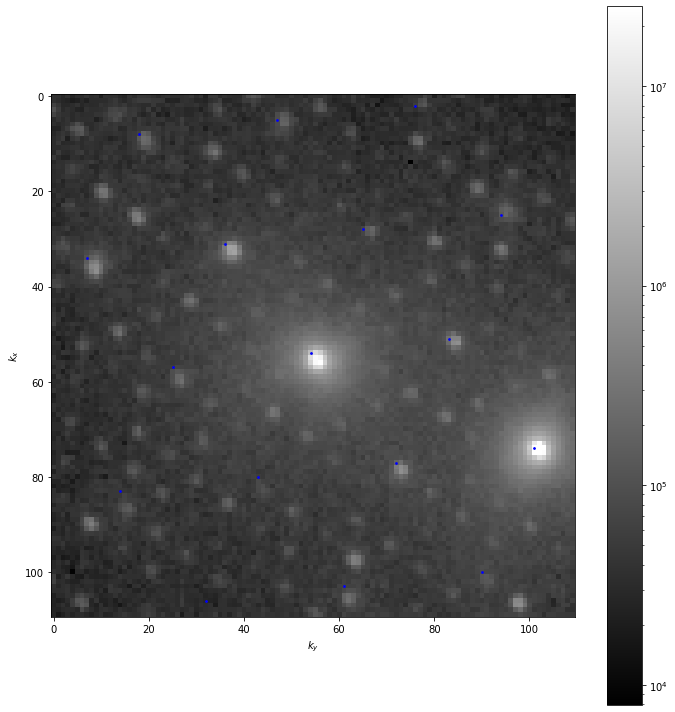

In [30]:
fig,ax=plt.subplots(figsize=(10,10),tight_layout=True)
im=ax.imshow(I[9,65,65,:,:],cmap='gray', norm=colors.LogNorm(vmin=10**3.9, vmax=10**7.4))
cb=plt.colorbar(im,ax=ax)
ax.set_xlabel(r'$k_y$')
ax.set_ylabel(r'$k_x$')
ax.set_aspect('equal')

# ax.scatter(40,14)
# ax.scatter(com_ij[:,1],com_ij[:,0],color='b',s=3)
ax.scatter(com.x_i[:,1],com.x_i[:,0],color='b',s=3)
# ax.scatter(spot_ij[:,1],spot_ij[:,0],color='b',s=3)

In [46]:
spot_pos_refine(1, data, 40, 14)

(1,
 39.884530734003036,
 14.122144024953302,
 152391524.47943023,
 0.16808424739299793,
 0.038294108390237336,
 5835697.556168808,
 792044.2054571027,
 577903.7238626815)

In [10]:
from COM import *

In [11]:
crop=np.full((128,128),True)
crop[:,85:]=False

In [27]:
com=COM(data=I[9,65,65,:,:],radius=0)

In [37]:
com=COM(data=(I[9,65,65]),k0=[66,65],k1=[69,95],k2=[42,81],i_range=np.array([[-3,2],[-2,2],[-1,2],[0,2],
                    [-2,1],[-1,1],[0,1],[1,1],
                    [-2,0],[-1,0],[0,0],[1,0],[2,0],
                    [-1,-1],[0,-1],[1,-1],[2,-1],
                    [-1,-2],[0,-2],[1,-2],[2,-2],[3,-2]]),
crop=crop)

In [34]:
com.x_i

array([[ 12,  10],
       [ 14,  40],
       [ 16,  69],
       [ 39,  24],
       [ 40,  53],
       [ 42,  82],
       [ 63,   7],
       [ 65,  37],
       [ 67,  66],
       [ 89,  20],
       [ 91,  50],
       [ 93,  79],
       [114,   4],
       [115,  34],
       [117,  63]])

In [28]:
com.x_i

array([[  8,  18],
       [  5,  47],
       [  2,  76],
       [ 34,   7],
       [ 31,  36],
       [ 28,  65],
       [ 25,  94],
       [ 57,  25],
       [ 54,  54],
       [ 51,  83],
       [ 83,  14],
       [ 80,  43],
       [ 77,  72],
       [ 74, 101],
       [106,  32],
       [103,  61],
       [100,  90]])

In [22]:
com_ij=com.generate_com()

IndexError: index 110 is out of bounds for axis 0 with size 110

In [43]:
spot_pos_refine(1, np.log(I[9,65,65]), 10,12)

(1,
 10.13296995555416,
 12.153749948928454,
 35.01985259877798,
 0.2032733525959003,
 0.03157116160801159,
 1.1056174258847644,
 12.323573327992095,
 0.19169741315654035)

In [39]:
com_ij

array([[ 12.13589008,  10.12740416],
       [ 14.14492704,  39.93829294],
       [ 16.3129124 ,  69.12540534],
       [ 38.69815531,  23.97344378],
       [ 40.27986574,  52.95417253],
       [ 42.37185365,  81.95007724],
       [ 62.88285367,   7.18950537],
       [ 64.80153849,  36.98236076],
       [ 66.81500132,  65.88978508],
       [ 88.91594438,  20.45764255],
       [ 90.81791645,  49.64140208],
       [ 92.76578264,  78.81921956],
       [113.99838541,   4.11670156],
       [115.10812759,  33.86285406],
       [116.86584687,  62.96648505]])

In [58]:
average_dist_direction(spot_ij, com.lines)

array([29.3913294 , 29.25690615, 29.27707054])

In [53]:
def generate_com(data,x_i):
    # I=I[9,65,65]
    # xi=com.x_i
    spot_ij_x=[]
    spot_ij_y=[]
    for x,y in x_i: 
        _,y_pos,x_pos,_,_,_,_,_,_=spot_pos_refine(1, (data), y, x)
        spot_ij_x.append(x_pos)
        spot_ij_y.append(y_pos)
    spot_ij=np.array([spot_ij_x,spot_ij_y]).T
    return spot_ij

In [56]:
spot_ij=generate_com(data=I[9,65,65], x_i=com.x_i)

In [31]:
com_ij

array([[ 12.01095664,  10.00976353],
       [ 14.01303623,  39.99407096],
       [ 16.02572551,  69.01016801],
       [ 38.97854303,  24.00715434],
       [ 40.02036979,  52.99373598],
       [ 42.03266353,  81.9904705 ],
       [ 62.99033338,   7.01374269],
       [ 64.98750193,  37.00900604],
       [ 66.9916562 ,  65.99291339],
       [ 88.9949368 ,  20.0462445 ],
       [ 90.98876137,  49.96888454],
       [ 92.98525496,  78.98530458],
       [113.99911472,   4.00851536],
       [115.00479279,  33.99951058],
       [116.9805738 ,  63.00350648]])

In [60]:
def generate_mask_arc(center,radius):
    i,j=np.mgrid[:400,:180]
    return (i-center[1])**2+(j-center[0])**2<=radius**2
def generate_mask_rect(xmin,xmax,ymin,ymax):
    '''
    x: (min,max)
    y: (min,max)
    '''
    mask=np.full((400,180),False)
    mask[xmin:xmax,ymin:ymax]=True
    return mask
disk1=generate_mask_arc([(20+152)/2,95],(152-20)/2)
disk2=generate_mask_arc([(20+152)/2,315],(152-20)/2)
mask=generate_mask_rect(95, 315,20, 152)
mask_stadium=mask| disk1 | disk2

In [68]:
ave_dist_j=np.zeros((I.shape[0],I.shape[1],I.shape[2],3))
# b1_store=np.zeros((I.shape[0],I.shape[1],I.shape[2],2))
# b2_store=np.zeros((I.shape[0],I.shape[1],I.shape[2],2))
for T_idx in [9]:
# for T_idx in range(I.shape[0]):
    for i in range(I.shape[1]):
    # for i in [65]:
        print(f'{T_idx}:{i}',end='\r')
        for j in range(I.shape[2]):
        # for j in [65]:
            if mask_stadium[i,j]:
                data=I[T_idx,i,j]
                com=COM(data=data,k0=[66,65],k1=[69,95],k2=[42,81],i_range=np.array([[-3,2],[-2,2],[-1,2],[0,2],
                    [-2,1],[-1,1],[0,1],[1,1],
                    [-2,0],[-1,0],[0,0],[1,0],[2,0],
                    [-1,-1],[0,-1],[1,-1],[2,-1],
                    [-1,-2],[0,-2],[1,-2],[2,-2],[3,-2]]),
crop=crop)
                spot_ij=generate_com(data=data, x_i=com.x_i)
                ave_dist_j[T_idx,i,j]=average_dist_direction(spot_ij,com.lines)

ValueError: attempt to get argmax of an empty sequence

In [ ]:
fig,axs=plt.subplots(1,3,figsize=(10,10),gridspec_kw=dict(wspace=0.8))
for idx in range(3):
    im=axs[idx].imshow(ave_dist_j[9,:,:,idx]*np.where(~mask_stadium,np.nan,1))
    ax_inset=axs[idx].inset_axes([1,0,0.1,1],transform=axs[idx].transAxes)
    plt.colorbar(im,cax=ax_inset)
    axs[idx].set_title(T[9])
    axs[idx].set_aspect('equal')

In [67]:
ave_dist_j[9,65,65]

array([29.3913294 , 29.25690615, 29.27707054])

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
x=np.linspace(-3,2)
y=np.exp(-x*x)

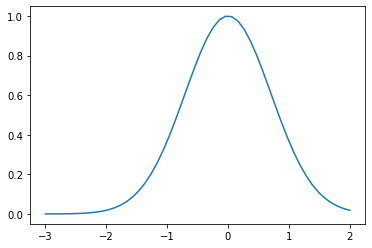

In [5]:
plt.plot(x,y)

In [6]:
np.sum(x*y)/(np.sum(y))

-0.0041575480964431265

In [52]:
y1=y+1

In [53]:
np.sum(x*y1)/(np.sum(y1))

-0.3723328502640098

In [ ]:
def 

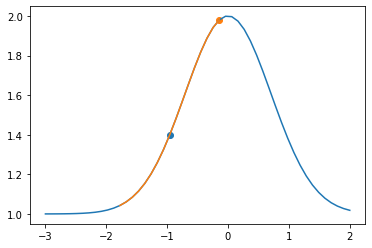

In [106]:
plt.plot(x,y1)
plt.plot(x[20-8:20+8+1],y1[20-8:20+8+1])
plt.scatter(x[20],y1[20])
plt.scatter(x[28],y1[28])

In [ ]:
plt.plot()

In [101]:
np.sum(y1[20-8:20+8+1]*np.arange(17))/np.sum(y1[20-8:20+8+1])

9.070500338017004

In [102]:
np.sum(y1[20-8:20+8+1]*np.arange(20-8,20+8+1))/np.sum(y1[20-8:20+8+1])

21.070500338017002

In [105]:
20-8+9.07

21.07

In [18]:
from scipy import ndimage


In [19]:
a = np.array(([0,0,0,0],
              [0,1,1,0],
              [0,1,1,0],
              [0,1,1,0]))

In [20]:
ndimage.center_of_mass(a)

(2.0, 1.5)

In [21]:
a1=a+1

In [22]:
ndimage.center_of_mass(a1)

(1.6363636363636365, 1.5)

In [2]:
y

NameError: name 'y' is not defined

In [40]:
np.abs(x).argmin()

29

In [107]:
def com(x0,radius=3):
    x0=round(x0)
    y_shift=y1[x0-radius:x0+radius+1]
    y_shift=y_shift-y_shift.min()
    idx= np.sum(y_shift*np.arange(x0-radius,x0+radius+1))/np.sum(y_shift)
    return idx
    # return x[round(idx)]


In [108]:
y1.shape[0]//2

25

In [109]:
com(20.,radius=8)

23.79091649000284

In [111]:
x0_old=20
x0_new=com(x0_old,radius=8)
while abs(x0_new-x0_old)>0.1:
    x0_old=x0_new
    x0_new=com(x0_old)
    print(x0_new)


25.272071154394922
26.21277791963991
27.137670895737212
28.031880562564318
28.85410286372517
29.43116199469752
29.43116199469752


In [112]:
x[29]

-0.04081632653061229

In [113]:
x[30]

0.06122448979591866

In [67]:
com(51)

51.49781316089143

In [33]:
radius=3
x0=0.5
xmin,xmax=x[x.shape[0]//2-radius],x[x.shape[0]//2+radius+1]
yy=y[x.shape[0]//2-radius:x.shape[0]//2+radius+1]

In [34]:
xmin

-0.7551020408163263

In [35]:
xmax

-0.04081632653061229

In [36]:
yy

array([0.56542417, 0.65279707, 0.73813873, 0.81743599, 0.88659543,
       0.94178807, 0.97979867])

In [26]:
x[x.shape[0]//2]

-0.44897959183673475

In [19]:
com(x,y1)

-0.34693877551020424

In [37]:
com(x,yy)

-2.693877551020408